Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.  
  
**Цель**  
Предсказать вероятность покупки в течение 90 дней  
  
**Задачи**  
● Изучить данные  
● Разработать полезные признаки  
● Создать модель для классификации пользователей  
● Улучшить модель и максимизировать метрику roc_auc  
● Выполнить тестирование  
  
**Данные:**

`apparel-purchases` - история покупок  
● client_id идентификатор пользователя  
● quantity количество товаров в заказе  
● price цена товара  
● category_ids вложенные категории, к которым отнсится товар  
● date дата покупки  
● message_id идентификатор сообщения из рассылки  

`apparel-messages` - история рекламных рассылок  
● bulk_campaign_id идентификатор рекламной кампании  
● client_id идентификатор пользователя  
● message_id идентификатор сообщений  
● event тип действия  
● channel канал рассылки  
● date дата рассылки  
● created_at точное время создания сообщения  

`apparel-target_binary` - совершит ли клиент покупку в течение следующих 90 дней  
● client_id идентификатор пользователя  
● target целевой признак  

## Подготовка данных

In [1]:
!pip install phik -q

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import phik
TEST_SIZE = 0.25
RANDOM_STATE = 42


Загружаем данные

In [3]:
data_messages = pd.read_csv('apparel-messages.csv')  
data_purchases = pd.read_csv('apparel-purchases.csv')  
data_target = pd.read_csv('apparel-target_binary.csv')  

Посмотрим на общую информацию и на первые 5 строк датасета

In [4]:
display (data_messages.info())
display (data_messages.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [5]:
display (data_purchases.info())
display (data_purchases.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [6]:
display (data_target.info())
display (data_target.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Приведем даты к соответствующему типу:

In [7]:
data_messages['date'] = pd.to_datetime(data_messages['date'], errors='coerce')
data_messages['created_at'] = pd.to_datetime(data_messages['created_at'], errors='coerce')
data_purchases['date'] = pd.to_datetime(data_purchases['date'], errors='coerce')

In [8]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [9]:
data_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


Проверим наличие пустых значений в таблицах.

In [10]:
display('Пропуски в таблице "история покупок"')
display (data_messages.isna().sum())
display('Пропуски в таблице "история рекламных рассылок"')
display(data_purchases.isna().sum())
display('Пропуски в таблице таргета')
display(data_target.isna().sum())

'Пропуски в таблице "история покупок"'

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

'Пропуски в таблице "история рекламных рассылок"'

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

'Пропуски в таблице таргета'

client_id    0
target       0
dtype: int64

Во всех таблицах пропуски отсутствуют

Посмотрим на уникальные значения в столбцах.

In [11]:
def unique_columns (df, columns):
    for column in columns:
        print(column)
        print(df[column].unique(), '\n')
        
unique_columns (data_messages, ['event', 'channel'])

event
['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain' 'close'] 

channel
['email' 'mobile_push'] 



Проверим явные дубликаты.

In [12]:
print (f'Количество явных дубликатов в таблице "история покупок": {data_messages.duplicated().sum()}')
print (f'Количество явных дубликатов в таблице "история рекламных рассылок": {data_purchases.duplicated().sum()}')
print (f'Количество явных дубликатов в таблице таргета: {data_target.duplicated().sum()}')

Количество явных дубликатов в таблице "история покупок": 48610
Количество явных дубликатов в таблице "история рекламных рассылок": 73020
Количество явных дубликатов в таблице таргета: 0


В 2х таблицах найдены явные дубликаты, удалим их

In [13]:
data_messages = data_messages.drop_duplicates()
data_purchases = data_purchases.drop_duplicates()

В таблицах с историей покупок и рекламных рассылок, оставим только тех клиентов, которые есть в таргете.

In [14]:
data_messages = data_messages[data_messages['client_id'].isin(data_target['client_id'])]
data_purchases = data_purchases[data_purchases['client_id'].isin(data_target['client_id'])]

В ходе предобработки данных мы привели даты к соответствующему типу, выявили явные дубликаты и удаллили их. В таблицах с историей покупок и рекламных рассылок, оставили только тех клиентов, которые есть в таргете.

### Исследовательский анализ данных

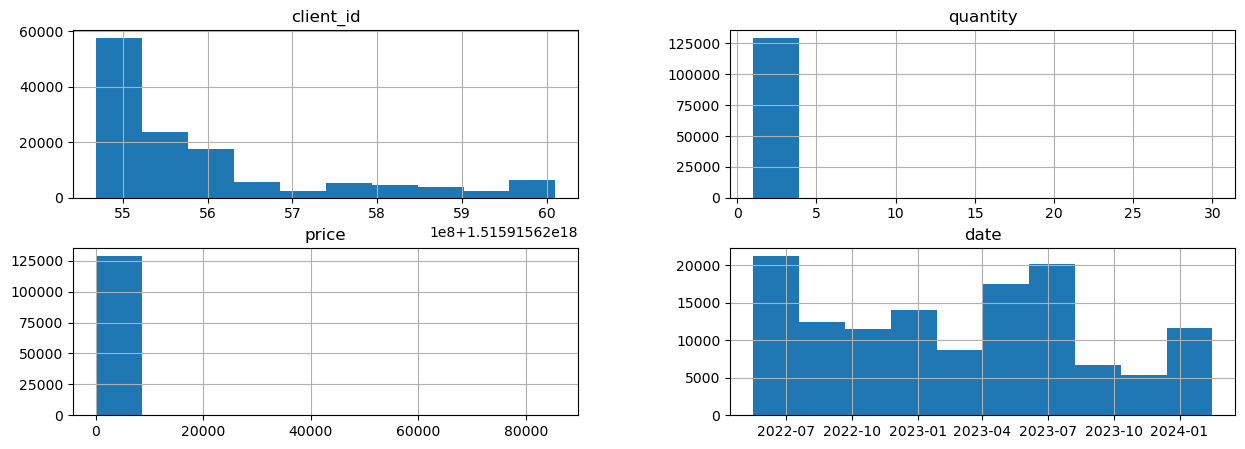

In [15]:
data_purchases.hist(figsize=(15, 5));

Из гистограмм выше, видно, что в некоторых данных есть выбивающиеся значения. Рассмотрим данные подробнее.

,price
count,129188.000000
mean,1264.532766
std,1375.016339
min,1.000000
25%,399.000000
50%,999.000000
75%,1750.000000
max,85499.000000


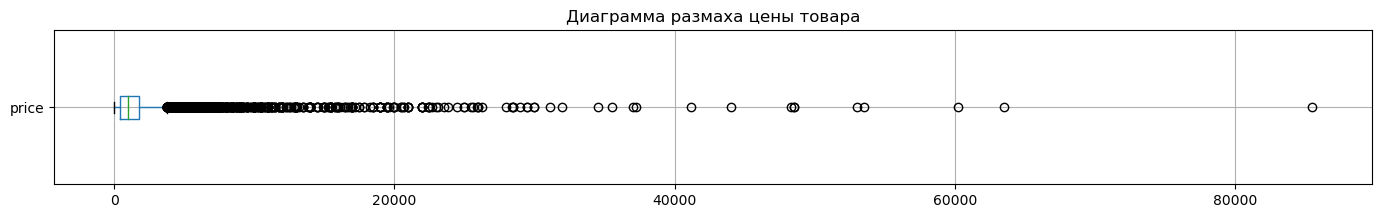

In [16]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data_purchases[['price']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха цены товара');
display(data_purchases[['price']].describe())

Распределение цен сильно варьируется, с большим количеством значений в диапазоне от 399 до 1750 единиц. Максимальное значение 85499 может указывать на дорогостоящий товар.

Посмотрим в какие года совершались покупки.

In [17]:
data_purchases['year'] = data_purchases['date'].dt.year

,year
count,129188.000000
mean,2022.606357
std,0.583507
min,2022.000000
25%,2022.000000
50%,2023.000000
75%,2023.000000
max,2024.000000


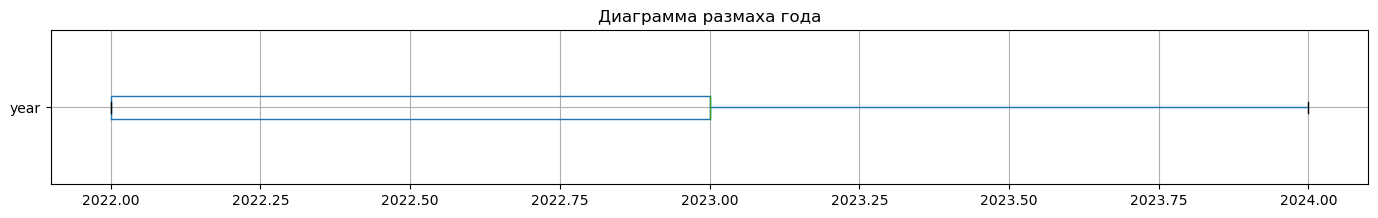

In [18]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data_purchases[['year']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха года');
display(data_purchases[['year']].describe())

Предоставлены данные за 2 года. С 2022 по 2024.

,quantity
count,129188.000000
mean,1.009420
std,0.220332
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,30.000000


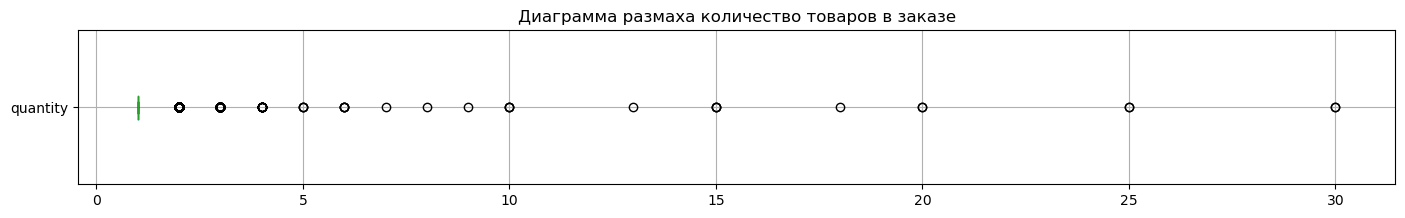

In [19]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data_purchases[['quantity']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха количество товаров в заказе');
display(data_purchases[['quantity']].describe())

Клиенты совершают покупки от 1 до 30 товаров в заказе.

Что бы в дальнейшем не путаться, переименуем столбцы с датами.

In [20]:
data_purchases = data_purchases.rename(columns={'date': 'purchase_date'})
data_messages = data_messages.rename(columns={'date': 'message_date'})

Начнем добавлять новые признаки.  
Посчитаем количество каждых действий пользователя.

In [21]:
# Создание сводной таблицы
event_counts = pd.pivot_table(data=data_messages, index='client_id', columns='event', aggfunc='size', 
                              fill_value=0).reset_index()

display(event_counts.head())

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1,1515915625468061003,5,0,0,0,0,5,1,154,0,0,0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0
3,1515915625468061100,1,0,0,1,0,157,1,267,1,0,0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0


Разобьем строчку с категориями на отдельные столбцы. Для начала нужно избавиться от лишних символов.

In [22]:
data_purchases['category_ids'] = data_purchases['category_ids'].str.replace(r"[\[\]'\s]", "", regex=True).str.split(',')

In [23]:
# Определяем максимальное количество категорий в любой строке
max_categories = data_purchases['category_ids'].apply(len).max()

# Создаем новые столбцы на основе категорий
category_columns = [f'category_{i+1}' for i in range(max_categories)]
data_purchases[category_columns] = pd.DataFrame(data_purchases['category_ids'].tolist(), index=data_purchases.index)

In [24]:
data_purchases.head()

,client_id,quantity,price,category_ids,purchase_date,message_id,year,category_1,category_2,category_3,category_4,category_5
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,2022,4,28,57,431,None
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,2022,4,28,57,431,None
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,2022,4,28,57,431,None
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,2022,4,28,244,432,None
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,2022,4,28,49,413,None


In [25]:
data_purchases.isna().sum()

client_id             0
quantity              0
price                 0
category_ids          0
purchase_date         0
message_id            0
year                  0
category_1            0
category_2         3360
category_3         3360
category_4         4096
category_5       128843
dtype: int64

Видим что 5я категория встречается очень редко. Создадим новую таблицу, содержащую ай ди пользователя и первые 4 категории купленного товара.

In [26]:
data_category = data_purchases[['client_id', 'category_1', 'category_2', 'category_3', 'category_4']]

Посмотрим на пропуски во 2й категории.

In [27]:
data_category[data_category['category_2'].isna()].head()

,client_id,category_1,category_2,category_3,category_4
14848,1515915625649908756,None,None,None,None
22153,1515915625558323436,,None,None,None
32281,1515915625578652401,None,None,None,None
32283,1515915625578652401,None,None,None,None
33447,1515915625468141353,None,None,None,None


Удалим пропуски в таблице.

In [28]:
data_category = data_category.dropna()

Приведем новые категории к целочисленному типу.

In [29]:
data_category[['category_1', 'category_2', 'category_3', 'category_4']] = data_category[['category_1', 'category_2', 
                                                                            'category_3', 'category_4']].astype('int')

Подсчитаем для каждого клиента общее число покупок и общую сумму всех покупок.

In [30]:
# Подсчет общего количества покупок для каждого клиента
total_purchases = data_purchases.groupby('client_id').size().reset_index(name='total_purchases')

# Подсчет общей суммы покупок для каждого клиента
total_spent = data_purchases.groupby('client_id')['price'].sum().reset_index(name='total_spent')

Подсчитаем общее количество действий по каналам рассылки.

In [31]:
purchase_channels = pd.pivot_table(data=data_messages, index='client_id', columns='channel', aggfunc='size', fill_value=0
                                   ).reset_index()
display(purchase_channels.head())

channel,client_id,email,mobile_push
0,1515915625468060902,177,0
1,1515915625468061003,165,0
2,1515915625468061099,182,94
3,1515915625468061100,0,428
4,1515915625468061170,202,91


Объединим все данные в одну таблицу

In [32]:
client_summary = total_purchases.merge(data_category, on='client_id').merge(event_counts, on='client_id')
client_summary = client_summary.merge(total_spent, on='client_id').merge(purchase_channels, on='client_id')
client_summary = client_summary.merge(data_target, on='client_id')
client_summary.head()

,client_id,total_purchases,category_1,category_2,category_3,category_4,click,close,complain,hard_bounce,...,open,purchase,send,soft_bounce,subscribe,unsubscribe,total_spent,email,mobile_push,target
0,1515915625468060902,5,4,27,176,458,10,0,0,0,...,35,5,126,0,0,1,4795.0,177,0,0
1,1515915625468060902,5,4,28,260,420,10,0,0,0,...,35,5,126,0,0,1,4795.0,177,0,0
2,1515915625468060902,5,4,27,1828,1599,10,0,0,0,...,35,5,126,0,0,1,4795.0,177,0,0
3,1515915625468060902,5,4,28,290,422,10,0,0,0,...,35,5,126,0,0,1,4795.0,177,0,0
4,1515915625468060902,5,4,28,244,432,10,0,0,0,...,35,5,126,0,0,1,4795.0,177,0,0


Удалим столбец 'client_id'. т.к. это был столбец с уникальными значениями, проверим явные дубликаты.

In [33]:
client_summary= client_summary.drop(['client_id'], axis=1)
print (f'Количество удаленных явных дубликатов в итоговой таблице: {client_summary.duplicated().sum()}')
client_summary = client_summary.drop_duplicates()

Количество удаленных явных дубликатов в итоговой таблице: 28487


Проверим пропуски

In [34]:
client_summary.isna().sum()

total_purchases    0
category_1         0
category_2         0
category_3         0
category_4         0
click              0
close              0
complain           0
hard_bounce        0
hbq_spam           0
open               0
purchase           0
send               0
soft_bounce        0
subscribe          0
unsubscribe        0
total_spent        0
email              0
mobile_push        0
target             0
dtype: int64

На основе анализа исходных таблиц, нами были созданы новые признаки. Посмотрим на корреляцию данных.

interval columns not set, guessing: ['total_purchases', 'category_1', 'category_2', 'category_3', 'category_4', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'total_spent', 'email', 'mobile_push', 'target']


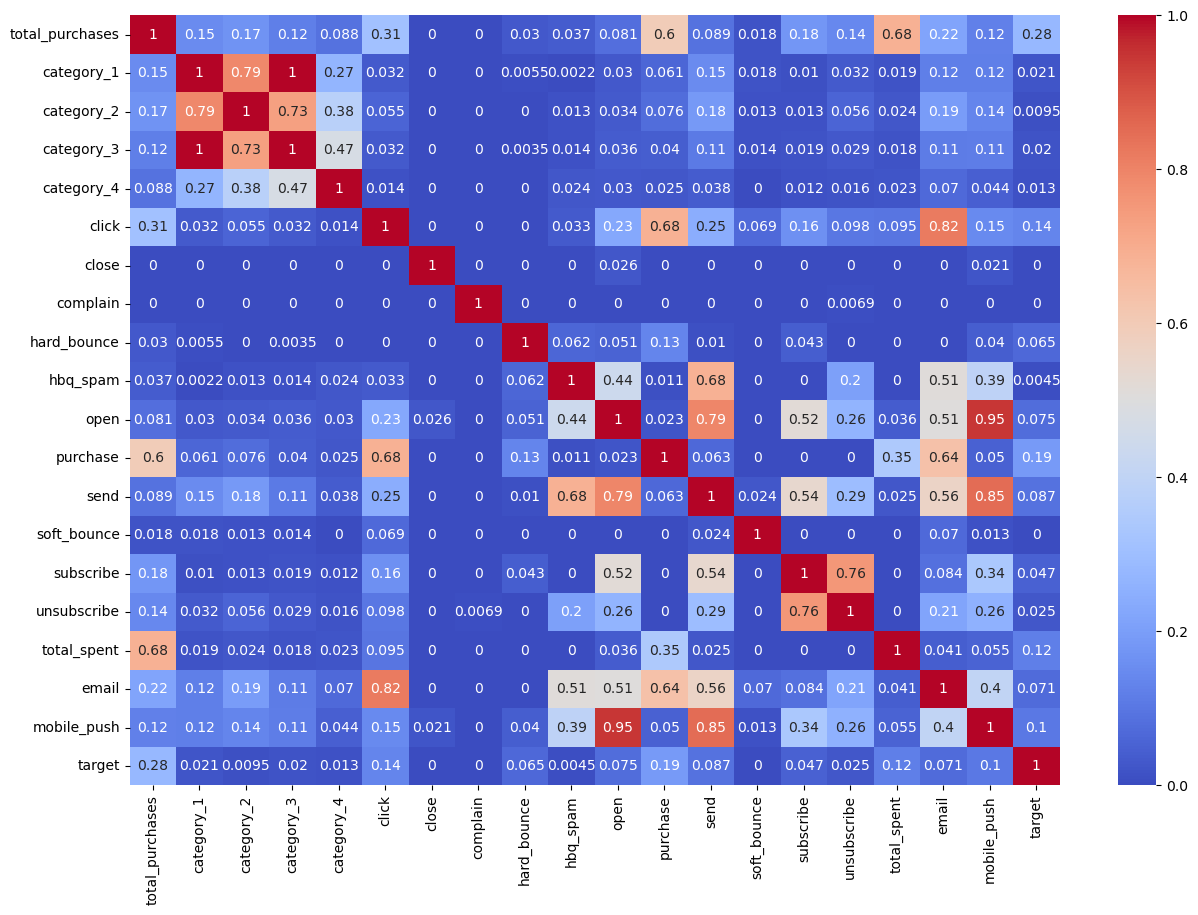

In [35]:
# Вычислим матрицу корреляции с использованием phik
corr_matrix = client_summary.phik_matrix()

# Визуализируем матрицу корреляции

plt.figure(figsize = (15, 10))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.show()

Видим, что между категориями есть большая корреляция. Оставим только первую.

In [36]:
client_summary = client_summary.drop(['category_2', 'category_3', 'category_4'], axis=1)

## Создание модели

In [37]:
# загружаем данные

X = client_summary.drop(['target'], axis=1)
y = client_summary['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = client_summary['target']
)

X_train.shape, X_test.shape

((57372, 16), (19125, 16))

In [38]:
ohe_columns = X.select_dtypes(include='object').columns.tolist()
num_columns = X.select_dtypes(include='number').columns.tolist()

In [39]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [40]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [41]:
param_grid = [
   
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=42, solver='liblinear', penalty='l1', class_weight='balanced')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
     },
     # словарь для модели CatBoostClassifier()    
        {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
        'models__iterations': [100, 200, 300],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__l2_leaf_reg': [1, 3, 5, 7],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
        # словарь для модели LGBMClassifier()
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': [50, 100, 150],
        'models__num_leaves': [31, 50, 70],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
    
]

In [42]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
   )
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

[LightGBM] [Info] Number of positive: 1709, number of negative: 55663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1595
[LightGBM] [Info] Number of data points in the train set: 57372, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['total_purchases',
                                                   'category_1', 'click',
                                                   'close', 'complain',
                                                   'hard_bounce', 'hbq_spam',
                 

In [43]:
# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика roc auc score на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика roc auc score на тестовой выборке: 0.9000106369399652


В ходе работы был проведен анализ и обработка данных, а также разработаны и обучены модели для задачи бинарной классификации с целью предсказания вероятности покупки пользователем в течение 90 дней.  
Модель показала превосходный результат. 